## This notebook explores learned policies from the policies agents:

In [8]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc

import os
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [9]:
log_path = os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN')
logs = os.listdir(log_path)
logs

['20200610-232039',
 '20200610-232703',
 '20200611-085213',
 '20200611-172110',
 '20200612-134052',
 '20200613-144629']

In [10]:
log_num = 0
models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN', logs[log_num]))
actions_bins = np.load(os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN', logs[log_num], 'action_bins.npy'))
model_path = os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN', logs[log_num])

In [11]:
os.listdir(model_path)

['action_bins.npy', 'main_net.h5']

In [12]:
# actions_bins = np.array([0, 0.1, 1])
# actions_bins = np.array([0, 0.2])
# actions_bins = np.array([0, 0.5])
n_actions = len(actions_bins)
c_env = CollectionsEnv(continuous_reward=False)
environment = DiscretizedActionWrapper(c_env, actions_bins)
environment = StateNormalization(environment)

Setting
New action space: Discrete(2)


In [13]:
config = DefaultConfig()
agent = DQNAgent(environment, 'DDQN', training=False, config=DefaultConfig())
agent.load(model_path)

In [14]:
w_points = 60
l_points = 60

w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = environment.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))

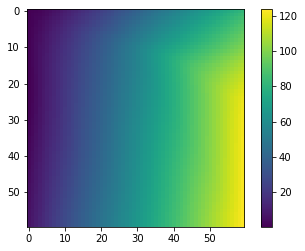

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(z)
fig.colorbar(im)

Text(0.5, 1.0, 'Simplest default with labels')

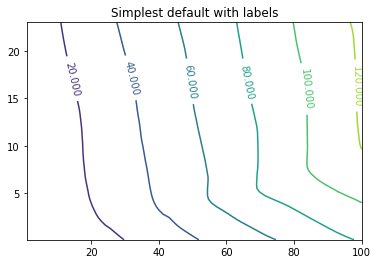

In [16]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

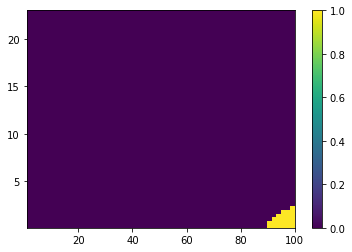

In [17]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

elementary check

In [18]:
fixed_obs = np.array([0.1, 100])
obs = environment.observation(fixed_obs)
agent.main_net.predict_on_batch(obs[None,:])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[80.86023, 81.15573]], dtype=float32)>

In [19]:
environment.observation((0.11,100))

array([4.36140381e-04, 9.90000000e-01])

In [20]:
w_points = 60
l_points = 60
lam_lim = 3
l = np.linspace(environment.observation_space.low[0], lam_lim, l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, environment.observation((3,100))[0], l_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = environment.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))

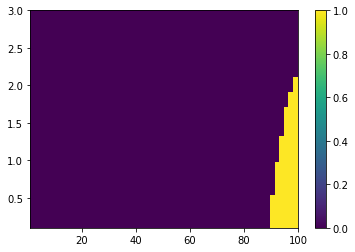

In [21]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Value function')

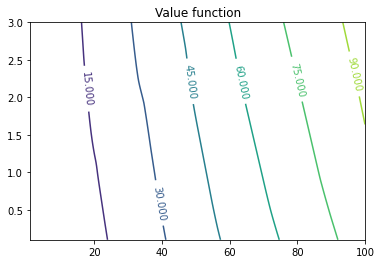

In [22]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')

[INFO] [2020-06-19 19:06:54,794] [AAV] - Instantiated @ AAV
[INFO] [2020-06-19 19:06:54,806] [OAV] - Launching the value function procedure.
[INFO] [2020-06-19 19:06:54,807] [OAV] - Computing the value function on (0.00, 16.83].
[INFO] [2020-06-19 19:06:54,815] [OAV] - Computing the value function on (16.83, 18.70].
[INFO] [2020-06-19 19:06:56,464] [OAV] - Computing the value function on (18.70, 20.78].
[INFO] [2020-06-19 19:06:57,516] [OAV] - Computing the value function on (20.78, 23.08].
[INFO] [2020-06-19 19:06:58,542] [OAV] - Computing the value function on (23.08, 25.65].
[INFO] [2020-06-19 19:06:59,384] [OAV] - Computing the value function on (25.65, 28.50].
[INFO] [2020-06-19 19:07:00,237] [OAV] - Computing the value function on (28.50, 31.66].
[INFO] [2020-06-19 19:07:01,171] [OAV] - Computing the value function on (31.66, 35.18].
[INFO] [2020-06-19 19:07:01,937] [OAV] - Computing the value function on (35.18, 39.09].
[INFO] [2020-06-19 19:07:03,185] [OAV] - Computing the valu

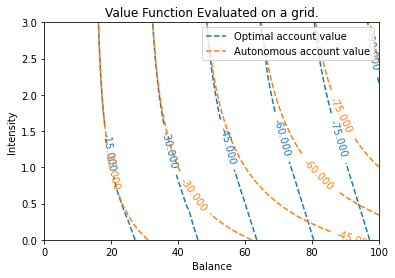

In [23]:
from dcc import OAV, Parameters, AAV
p = Parameters()
w_start = 100
oav = OAV(p, w_start, lmax=3)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

In [24]:
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')

Text(0.5, 1.0, 'Value function')

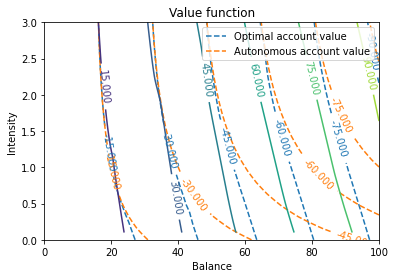

In [25]:
fig

In [54]:
from tqdm import tqdm
from IPython.display import clear_output

def create_value_map_policy(wpoints=60, lpoints=60):
    llim = 3
    # setup meshgrid
    wgrid = np.linspace(agent.env.observation_space.low[1] , agent.env.observation_space.high[1], wpoints)
    lgrid = np.linspace(agent.env.observation_space.low[0] , 3, lpoints)
    
    w_normalized = np.linspace(0, 1, wpoints)
    l_normalized = np.linspace(0, environment.observation((llim,100))[0], lpoints)
    
    ww, ll = np.meshgrid(w_normalized, l_normalized)
    vs = np.zeros_like(ww)
    
    for i, xp in enumerate(tqdm(ww[0, :])):
        for j, yp in enumerate(lln[:,0]):
            agent.env.env.starting_state = np.array([yp, xp])
            # agent.env.current_state = np.array([yp, xp])
            vs[j, i] = np.mean(agent.evaluate(200))
        clear_output(wait=True)
    return ww, ll, vs
    
wg, lg, wg = create_value_map_policy(wpoints=10, lpoints=10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Avg. reward over 200 episodes: 75.4321
Avg. reward over 200 episodes: 74.5862
Avg. reward over 200 episodes: 73.7491
Avg. reward over 200 episodes: 73.5856
Avg. reward over 200 episodes: 76.0778
Avg. reward over 200 episodes: 74.5081
Avg. reward over 200 episodes: 74.9827
Avg. reward over 200 episodes: 74.8040
Avg. reward over 200 episodes: 74.2657
Avg. reward over 200 episodes: 74.9139


  0%|                                                                                           | 0/10 [02:09<?, ?it/s]

Avg. reward over 200 episodes: 75.6405


IndexError: index 10 is out of bounds for axis 0 with size 10

In [53]:
lln[:, 0]

array([0.        , 0.00213854, 0.00427708, 0.00641561, 0.00855415,
       0.01069269, 0.01283123, 0.01496977, 0.0171083 , 0.01924684,
       0.02138538, 0.02352392, 0.02566245, 0.02780099, 0.02993953,
       0.03207807, 0.03421661, 0.03635514, 0.03849368, 0.04063222,
       0.04277076, 0.0449093 , 0.04704783, 0.04918637, 0.05132491,
       0.05346345, 0.05560198, 0.05774052, 0.05987906, 0.0620176 ,
       0.06415614, 0.06629467, 0.06843321, 0.07057175, 0.07271029,
       0.07484883, 0.07698736, 0.0791259 , 0.08126444, 0.08340298,
       0.08554151, 0.08768005, 0.08981859, 0.09195713, 0.09409567,
       0.0962342 , 0.09837274, 0.10051128, 0.10264982, 0.10478836,
       0.10692689, 0.10906543, 0.11120397, 0.11334251, 0.11548104,
       0.11761958, 0.11975812, 0.12189666, 0.1240352 , 0.12617373])

In [27]:
agent.env.starting_state = np.array([1.0, 40.])

In [28]:
agent.env.observation(agent.env.starting_state)

array([0.0391581, 0.39     ])

In [29]:
agent.env.reset()

array([4.3614034e-04, 9.9000001e-01], dtype=float32)

In [30]:
agent.env.starting_state

array([ 1., 40.])

In [31]:
agent.env.current_state = np.array([1.0, 40.])

In [32]:
agent.env.current_state

array([ 1., 40.])

In [33]:
agent.env.reset()

array([4.3614034e-04, 9.9000001e-01], dtype=float32)

In [34]:
agent.env.current_state

array([ 1., 40.])

In [35]:
agent.env.step(0)

(array([4.211759e-04, 9.900000e-01], dtype=float32), 0.0, False, None)

In [36]:
agent.env.current_state

array([ 1., 40.])

In [37]:
agent.env.observation_space.low

array([0.1, 1. ], dtype=float16)

In [38]:
agent.env.observation_space.shape[0]

2

In [39]:
agent.env.reset()

array([4.3614034e-04, 9.9000001e-01], dtype=float32)

In [40]:
environment.convert_back(agent.env.reset())

array([  0.11, 100.  ], dtype=float32)

# lets value this policy:

In [41]:
rewards = agent.evaluate(200)

Avg. reward over 200 episodes: 74.1908


In [42]:
np.mean(rewards)

74.19078284122917

[INFO] [2020-06-19 19:07:30,410] [AAV] - Instantiated @ AAV


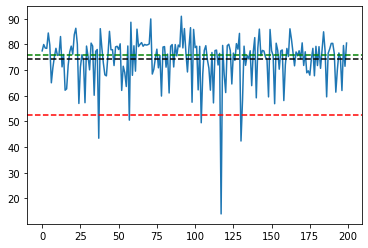

In [43]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')
plt.axhline(-aav.u(0.11 + 2, 100) - 2*p.c, color='green', linestyle='--')

NameError: name 'rew_aav' is not defined

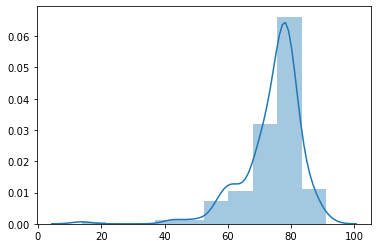

In [44]:
import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(rewards, ax=ax, bins=10)
sns.distplot(rew_aav, ax=ax, bins=10)
ax.axvline(np.mean(rewards), color='black', linestyle='--')
ax.axvline(np.mean(rew_aav), color='red', linestyle='--')
# ax.axvline(u, color='green', linestyle='--')

In [ ]:
# agent.evaluate(100)

In [ ]:
def sim():
    rewards = []
    w_states = []
    l_states = []
    actions = []
    for i in range(500):
        episode_reward = 0
        done = False
        state = environment.reset()
        while not done:
            # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
            #action, q = agent.get_action(state, epsilon=0.0)
            action = 0
            actions.append(action)
            state, reward, done, _ = environment.step(action)
            episode_reward += reward
            converted_state = environment.convert_back(state)
            w_states.append(converted_state[1])
            l_states.append(converted_state[0])
            if episode_reward>100:
                break
            if done:
                rewards.append(episode_reward)
    return rewards

rew_aav = sim()
        

In [ ]:
episode_reward

In [ ]:
#plt.plot(results['REINFORCE AB'])
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

Statespace path

In [ ]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        #action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if episode_reward>100:
            break
        if done:
            rewards.append(episode_reward)


In [ ]:
l_states[0]

In [ ]:
fig, ax = plt.subplots()
ax.plot(w_states, l_states, marker='x')
ax.set_xlabel('Balance')
ax.set_ylabel('Intensity')

In [ ]:
fig, ax = plt.subplots()
ax.plot(actions, marker='x')
ax.set_xlabel('steps')
ax.set_ylabel('Action size applied')

In [ ]:
plt.plot(rewards)

Test policy that separates linearly the statespace by y=x

In [ ]:
def dummy_policy(state):
    if state[1] > state[0]:
        return 0
    else:
        return 1

In [ ]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1000):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        action = dummy_policy(state)
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if done:
            rewards.append(episode_reward)

In [ ]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

In [ ]:
w_points = 60
l_points = 60

w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = dummy_policy(fixed_obs)

In [ ]:
plt.pcolor(ww, ll,z)
plt.colorbar()
plt.show()

In [ ]:
plt.contour(ww, ll, p)

In [ ]:
fig, ax = plt.subplots()

CS = ax.contour(ww, ll, p, levels=actions_bins.shape[0])

ax.clabel(CS, CS.levels, inline=True)

In [ ]:
environment.observation((np.array([10, 100])))

In [ ]:
environment.action(np.argmax(agent.main_net.predict_on_batch(environment.observation((np.array([0, 40])))[None,:])))

In [ ]:
agent.main_net.predict_on_batch(environment.observation((np.array([10, 100])))[None,:])

Too large rewards

In [ ]:
for i in range(500):
    rewards = []
    w_states = []
    l_states = []
    actions = []
    running_rew = []
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        # action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        running_rew.append(reward)
        if done:
            rewards.append(episode_reward)
    if episode_reward > 100:
            break
print(episode_reward)

In [ ]:
plt.plot(running_rew)

In [ ]:
sum(running_rew)

In [ ]:
plt.plot(w_states, l_states, marker='x')

In [ ]:
running_rew

In [ ]:
model5K.layer1.keras_api.call_and_return_all_conditional_losses(obs)

In [ ]:
tf.keras.models.load_model('dqn_5000e')